In [1]:
from devito import *
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
Lx = 100.0   # width of the mantle in the x direction []
Ly = 100.0   # thickness of the mantle in the y direction []
nx = 401     # number of points in the x direction
ny = 401     # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction []
dy = Ly / (ny - 1)  # grid spacing in the y direction []
g = 9.81  # gravity acceleration [m/s^2]
alpha = 0.025 # friction coefficient for natural channels in good condition
# Maximum wave propagation time [s]
Tmax = 1.
dt = 1/4500.
nt = (int)(Tmax/dt)
print(dt, nt)

0.00022222222222222223 4500


In [3]:
#from devito import Grid, TimeFunction, Function

grid = Grid(shape=(ny, nx), extent=(Ly, Lx))
eta = TimeFunction(name='eta', grid=grid, space_order=2)
M   = TimeFunction(name='M', grid=grid, space_order=2)
N   = TimeFunction(name='N', grid=grid, space_order=2)
h   = Function(name='h', grid=grid)
D   = Function(name='D', grid=grid)
M

M(t, x, y)

In [4]:
import numpy
# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Define initial eta, M, N
X, Y = numpy.meshgrid(x,y) # coordinates X,Y required to define eta, h, M, N

# Define constant ocean depth profile h = 50 m
h.data[:] = 50

# Define initial eta Gaussian distribution [m]
eta0 = 0.5 * numpy.exp(-((X-50)**2/10)-((Y-50)**2/10))

In [5]:
print(eta0.shape, h.data.shape)

(401, 401) (401, 401)


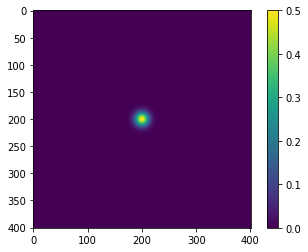

In [6]:
plt.imshow(eta0)
plt.colorbar()

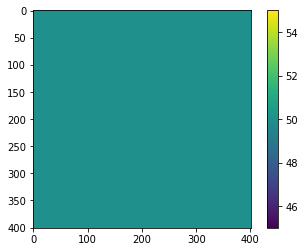

In [7]:
plt.imshow(h.data[:])
plt.colorbar()

In [8]:
# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + 50.

eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:] = D0.copy()

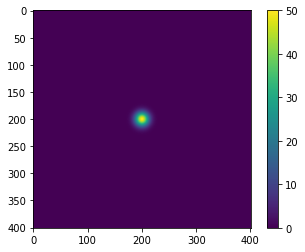

In [9]:
plt.imshow(M.data[0])
plt.colorbar()

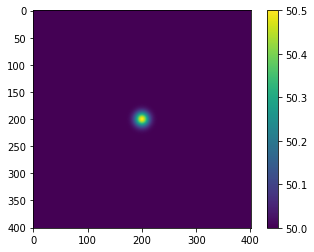

In [10]:
plt.imshow(D0)
plt.colorbar()

In [25]:
frictionTerm = g * alpha**2 * sqrt(M**2 + N**2)/ D**(7./3.)
frictionTerm

0.00613125*sqrt(M(t, x, y)**2 + N(t, x, y)**2)*D(x, y)**(-2.33333333333333)

In [12]:
from devito import Eq, solve
pde_eta = eta.dt + M.dxc + N.dyc
eq_eta = Eq(eta.forward, solve(pde_eta, eta.forward), subdomain=grid.interior)

x, y = grid.dimensions
t = grid.stepping_dim
bc_left = Eq(eta[t + 1, 0, y], eta[t + 1, 1, y])
bc_right = Eq(eta[t + 1, nx-1, y], eta[t + 1, nx-2, y])
bc_top = Eq(eta[t + 1, x, ny-1], eta[t + 1, x, ny-2])
bc_bottom = Eq(eta[t + 1, x, 0], eta[t + 1, x, 1])


In [26]:
pde_M = M.dt + (M**2/D).dxc + (M*N/D).dyc + g*D*eta.forward.dxc + frictionTerm*M
eq_M = Eq(M.forward, solve(pde_M, M.forward), subdomain=grid.interior)
pde_N = N.dt + (M*N/D).dxc + (N**2/D).dyc + g*D*eta.forward.dyc + frictionTerm*N
eq_N = Eq(N.forward, solve(pde_N, N.forward), subdomain=grid.interior)
eq_D =  Eq(D, eta.forward+h)
print(pde_eta)
eq_N

Derivative(M(t, x, y), x) + Derivative(N(t, x, y), y) + Derivative(eta(t, x, y), t)


Eq(N(t + dt, x, y), dt*(-0.00613125*sqrt(M(t, x, y)**2 + N(t, x, y)**2)*D(x, y)**(-2.33333333333333)*N(t, x, y) - 9.81*D(x, y)*Derivative(eta(t + dt, x, y), y) - Derivative(N(t, x, y)**2/D(x, y), y) - Derivative(M(t, x, y)*N(t, x, y)/D(x, y), x) + N(t, x, y)/dt))

In [14]:
from devito import Operator

optime = Operator([eq_eta, bc_left, bc_right, bc_top, bc_bottom, eq_M, eq_N, eq_D])

In [15]:
print(optime.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(struct dataobj *restrict D_vec, struct dataobj *restrict M_vec, struct dataobj *restrict N_vec, const float dt, struct dataobj *restrict eta_vec, struct dataobj *restrict h_vec, const float h_x, const float h_y, const int i0x_ltkn, const int i0x_rtkn, const int i0y_ltkn, const int i0y_rtkn, const int time_M, const int time_m, const int x_M, const int x_m, const in

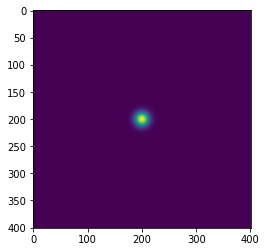

In [16]:
plt.imshow(eta.data[0])

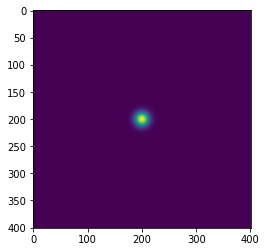

In [17]:
plt.imshow(M.data[0])

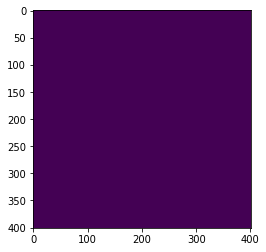

In [18]:
plt.imshow(N.data[0])

In [19]:
# Silence non-essential outputs from the solver.
configuration['log-level'] = 'ERROR'

# This is the time loop.
optime(time=nt, dt=dt)

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=5.6981199999999905, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.002590000000000017, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=32.70135499999992, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [20]:
eta.data

Data([[[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]],

      [[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

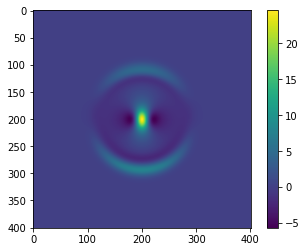

In [21]:
plt.imshow(M.data[1])
plt.colorbar()

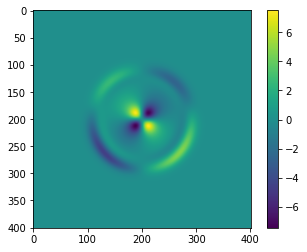

In [22]:
plt.imshow(N.data[1])
plt.colorbar()

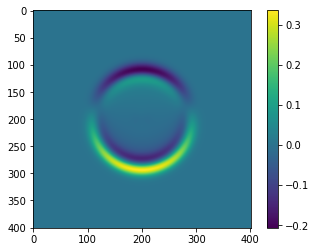

In [23]:
plt.imshow(eta.data[1])
plt.colorbar()